# Machine learning & results visualization

In [1]:
import pandas as pd
import numpy as np
import pickle
from time import time
import math
import matplotlib.pyplot as plt
import itertools
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn import mixture
from scipy import linalg
from sklearn.ensemble import RandomForestClassifier
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

%matplotlib inline
py.sign_in('juanluismoralperez', 'MUMjWF4QwNy8AtZW6WUq')

The aim of the project is to predict the elos for the season 2016 training a model using the data from the season 2015.

## Import the data 

### Season 2015

In [2]:
df_s5 = pd.read_pickle('pc_processed.pkl')
y_s5 = df_s5['league'].values
X_s5 = df = df_s5.drop('league', 1)
X_s5.head()

,champID,maxNumDeaths,mostChampionKillsPerSession,champ1R,champ2R,GoldEarned,MinionKills,PhysicalDamageDealt,MagicDamageDealt,DamageTaken,DoubleKills,TripleKills,QuadraKills,PentaKills,TurretsKilled,KDA,WinRate
summID,,,,,,,,,,,,,,,,,
20916990,39,13,22,1,1,12782.622951,216.213115,123844.983607,4727.622951,27892.295082,0.885246,0.098361,0.016393,0.000000,1.803279,3.911504,0.737705
52341179,131,16,31,1,1,12680.698925,132.731183,24586.946237,111389.580645,20344.580645,1.451613,0.172043,0.021505,0.000000,1.634409,2.957770,0.559140
43198302,76,14,24,0,0,12138.325397,80.087302,13620.880952,129682.658730,23255.206349,1.134921,0.222222,0.023810,0.007937,0.706349,3.936015,0.619048
25882203,81,14,30,3,3,12665.266667,132.683333,51381.016667,81216.966667,17159.183333,1.066667,0.216667,0.033333,0.016667,1.183333,3.700315,0.550000
37039090,5,16,19,1,1,12494.345679,88.950617,108348.024691,45091.740741,35364.592593,0.580247,0.049383,0.000000,0.000000,1.234568,1.632624,0.518519


### Season 2016

In [5]:
df_s6 = pd.read_pickle('pc_processed_2016.pkl')
y_s6 = df_s6['league'].values
X_s6 = df = df_s6.drop('league', 1)
X_s6.head()

,champID,maxNumDeaths,mostChampionKillsPerSession,champ1R,champ2R,GoldEarned,MinionKills,PhysicalDamageDealt,MagicDamageDealt,DamageTaken,DoubleKills,TripleKills,QuadraKills,PentaKills,TurretsKilled,KDA,WinRate
summID,,,,,,,,,,,,,,,,,
42787225,420,18,21,1,1,13607.882353,183.670588,185046.247059,1904.023529,35815.329412,1.647059,0.294118,0.058824,0.011765,2.635294,1.809595,0.611765
24231667,77,9,13,1,1,11733.472222,39.027778,44593.000000,70256.722222,29093.500000,0.333333,0.055556,0.000000,0.000000,0.527778,3.934211,0.611111
71930471,40,9,5,4,4,8519.022388,14.276119,6402.940299,7153.149254,12428.462687,0.022388,0.007463,0.000000,0.000000,0.320896,4.448276,0.537313
36857294,32,11,13,5,5,11377.364486,35.579439,18164.411215,89390.551402,27342.037383,0.317757,0.037383,0.000000,0.000000,0.355140,4.296552,0.607477
28292063,17,15,24,3,3,12921.182292,194.916667,30328.666667,107152.026042,21839.088542,0.604167,0.067708,0.010417,0.000000,1.494792,1.956193,0.520833


## Data split and feature engineering

We decided that the champion role is not relevant for the classification and also the specific champion the player has stadistic for is not relevant. Hence, 'champID', 'champ1R' and 'champ2R' are not considered as features.

In [63]:
X_s5 = X_s5[['maxNumDeaths', 'mostChampionKillsPerSession', 'GoldEarned', 'MinionKills',
      'PhysicalDamageDealt', 'MagicDamageDealt', 'DamageTaken', 'DoubleKills', 'TripleKills',
       'QuadraKills', 'PentaKills', 'TurretsKilled', 'KDA', 'WinRate']]
X_s6 = X_s6[['maxNumDeaths', 'mostChampionKillsPerSession', 'GoldEarned', 'MinionKills',
      'PhysicalDamageDealt', 'MagicDamageDealt', 'DamageTaken', 'DoubleKills', 'TripleKills',
       'QuadraKills', 'PentaKills', 'TurretsKilled', 'KDA', 'WinRate']]

We scale and normalize the features:

In [64]:
X_n = preprocessing.normalize(preprocessing.scale(X_s5))

## Feature selection

### Univariate Feature Selection

For a simple univariate feature selection we will use a SVC with a linear kernel and compare the performance:

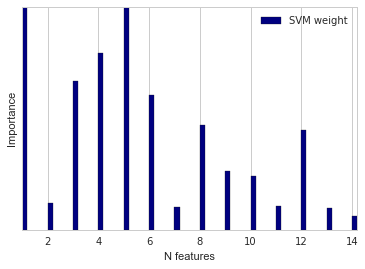

In [65]:
clf = SVC(kernel='linear')
clf.fit(X_n, y_s5)
svm_weights = (clf.coef_ ** 2).sum(axis=0)
svm_weights /= svm_weights.max()
X_indices = np.arange(X_s5.shape[-1])

plt.bar(X_indices + 1, svm_weights, width=.2, label='SVM weight', color='navy')
plt.xlabel('N features')
plt.ylabel('Importance')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

We can see that the Ranking for the most important features is:

1. maxNumDeaths
2. PhysicalDamageDealt
3. MinionKills
4. GoldEarned
5. MagicDamageDealt
6. DoubleKills

### Recursive Feature Elimination (RFE)

Now, we observe from the most important feature to all features and evaluate the best group of features to select the set of freatures. 

In [67]:
X_tr_, X_val, y_tr_, y_val = train_test_split(X_n, y_s5, test_size=0.4, random_state=0)
X_tr_ = pd.DataFrame(data=X_tr_, columns=X_s5.columns) 
X_val = pd.DataFrame(data=X_val, columns=X_s5.columns) 

train_acc, validation_acc = [], []

for i in range(1,X_n.shape[1]+1,1):
    estimator = SVC(kernel="linear")
    selector = RFE(estimator, i, step=1)
    selector = selector.fit(X_n, y_s5)
    feature_selection = selector.support_ 
    print(i,"features Selection by RFE are:\n", X_s5.columns[feature_selection])
    clsf = SVC(kernel="linear")
    clsf.fit(X_tr_[X_tr_.columns[feature_selection]], y_tr_)
    train_acc.append(clsf.score(X_tr_[X_tr_.columns[feature_selection]], y_tr_))
    validation_acc.append(clsf.score(X_val[X_val.columns[feature_selection]], y_val))
    print("Train Accuracy: ",train_acc[i-1] , "\tValidation Error: ", validation_acc[i-1])

1 features Selection by RFE are:
 Index(['maxNumDeaths'], dtype='object')
Train Accuracy:  0.308848080134 	Validation Error:  0.3075
2 features Selection by RFE are:
 Index(['maxNumDeaths', 'MinionKills'], dtype='object')
Train Accuracy:  0.312186978297 	Validation Error:  0.305
3 features Selection by RFE are:
 Index(['maxNumDeaths', 'MinionKills', 'DoubleKills'], dtype='object')
Train Accuracy:  0.320534223706 	Validation Error:  0.31
4 features Selection by RFE are:
 Index(['maxNumDeaths', 'GoldEarned', 'MinionKills', 'DoubleKills'], dtype='object')
Train Accuracy:  0.318864774624 	Validation Error:  0.31
5 features Selection by RFE are:
 Index(['maxNumDeaths', 'GoldEarned', 'MinionKills', 'PhysicalDamageDealt',
       'DoubleKills'],
      dtype='object')
Train Accuracy:  0.317195325543 	Validation Error:  0.3075
6 features Selection by RFE are:
 Index(['maxNumDeaths', 'GoldEarned', 'MinionKills', 'PhysicalDamageDealt',
       'MagicDamageDealt', 'DoubleKills'],
      dtype='object

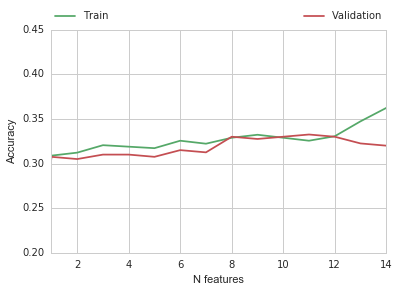

In [71]:
plt.plot([0]+train_acc, 'g', label= 'Train')
plt.plot([0]+validation_acc, 'r', label = 'Validation')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlim(1, 14)
plt.ylim(0.2, 0.45)
plt.xlabel('N features')
plt.ylabel('Accuracy')
plt.show()

### Feature ranking using trees


We rank the importance of the features and evaluate if the normalization and/or scale affects to this ranking.

#### Using raw data

In [72]:
def feature_importance(data, labels):
    forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
    forest.fit(data, labels)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(X_s5.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(data.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(data.shape[1]), indices)
    plt.xlim([-1, data.shape[1]])
    plt.show()

Feature ranking:
1. feature 3 (0.090046)
2. feature 0 (0.081286)
3. feature 6 (0.078958)
4. feature 2 (0.078431)
5. feature 1 (0.078064)
6. feature 12 (0.077932)
7. feature 5 (0.077468)
8. feature 13 (0.076535)
9. feature 4 (0.075999)
10. feature 7 (0.073790)
11. feature 11 (0.073437)
12. feature 8 (0.066072)
13. feature 9 (0.047329)
14. feature 10 (0.024654)


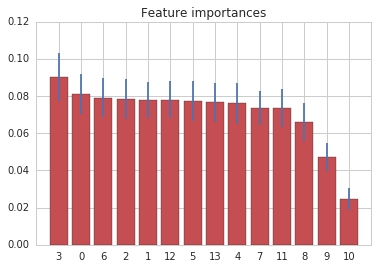

In [73]:
feature_importance(X_s5, y_s5)

#### Scaling the data

Feature ranking:
1. feature 3 (0.090046)
2. feature 0 (0.081286)
3. feature 6 (0.078958)
4. feature 2 (0.078431)
5. feature 1 (0.078064)
6. feature 12 (0.077932)
7. feature 5 (0.077468)
8. feature 13 (0.076535)
9. feature 4 (0.075999)
10. feature 7 (0.073790)
11. feature 11 (0.073437)
12. feature 8 (0.066072)
13. feature 9 (0.047329)
14. feature 10 (0.024654)


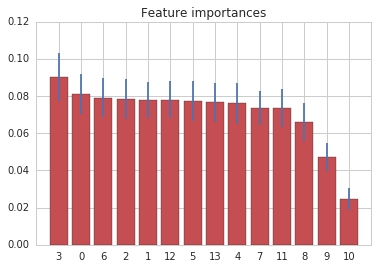

In [74]:
X_s =preprocessing.scale(X_s5)
feature_importance(X_s5, y_s5)

#### Normalizing and scaling the data

Feature ranking:
1. feature 0 (0.084024)
2. feature 3 (0.083484)
3. feature 1 (0.072318)
4. feature 5 (0.071791)
5. feature 12 (0.071603)
6. feature 6 (0.070979)
7. feature 13 (0.070141)
8. feature 7 (0.069962)
9. feature 4 (0.069944)
10. feature 2 (0.069444)
11. feature 8 (0.068032)
12. feature 10 (0.066406)
13. feature 11 (0.066329)
14. feature 9 (0.065541)


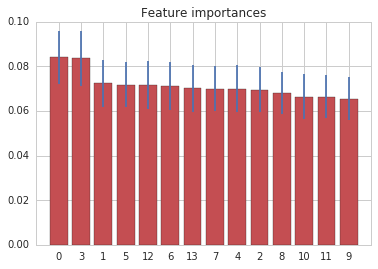

In [75]:
feature_importance(X_n, y_s5)

We can observe that scaling the data does not affect the feature importance but, on the other hand, the normalization do affect the feature ranking. 

# Unsupervised Clustering

Although we won't use an unsupervised clustering for predicting the data. We could calculate a siluette score to measure how well the data could be clusterized in 6 clusters.

## K-means

Source: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

In [ ]:
def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('% 9s   %.2fs    %i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

In [ ]:
labels = y_total
n_samples, n_features = X_total.shape
sample_size = n_samples
bench_k_means(KMeans(init='k-means++', n_clusters=5, n_init=10), name="k-means++", data=X_s5)

In [ ]:
k_means = KMeans(init='k-means++', n_clusters=5, n_init=10)
k_means.fit(X_s5_tr)

## GMM

Source: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html

In [ ]:
X = X_total[['GoldEarned', 'MinionKills', 'KDA']]

In [ ]:
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold','darkorange'])
def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

# Supervised classification (predicting the elo)

We perform a multi-label classification using different classifiers. We have seen that the best result is obtanined using this features:

In [8]:
X_s5 = X_s5[['maxNumDeaths', 'mostChampionKillsPerSession', 'GoldEarned',
       'MinionKills', 'PhysicalDamageDealt', 'MagicDamageDealt', 'DoubleKills',
       'QuadraKills', 'TurretsKilled', 'WinRate']]
X_s6 = X_s6[['maxNumDeaths', 'mostChampionKillsPerSession', 'GoldEarned',
       'MinionKills', 'PhysicalDamageDealt', 'MagicDamageDealt', 'DoubleKills',
       'QuadraKills', 'TurretsKilled', 'WinRate']]

## SVC

First, we will try to classify the data using a Support Vector Machine. 
We will use the model provided by sklearn: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

We use PCA to scale the dimensionality of the data:

In [9]:
pca = PCA()
pca.fit(preprocessing.scale(X_s5))
X_tr = pca.transform(preprocessing.scale(X_s5))
y_tr = y_s5
X_ts = pca.transform(preprocessing.scale(X_s6))
y_ts = y_s6

We will try two kernelized models: Linear and RBF.

In [14]:
clf = SVC(kernel='linear')
values = cross_val_score(clf, X_tr, y_tr, cv=10)
print('Mean Accuracy :', np.mean(values), '\tSTD: ', np.std(values))

Mean Accuracy : 0.394099622285 	STD:  0.00895650269304


In [15]:
clf = SVC(kernel='rbf')
values = cross_val_score(clf, X_tr, y_tr, cv=10)
print('Mean Accuracy :', np.mean(values), '\tSTD: ', np.std(values))

Mean Accuracy : 0.414378332894 	STD:  0.0073031966508


We perform a Grid Search and a 3-Fold Cross-Validation to optimize the hyper-parameters of the SVM. For more information on this method read http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html.

In [20]:
C_range = 10.0 ** np.arange(-4, 4)
gamma_range = 10.0 ** np.arange(-4, 4)
param_grid = {"gamma": gamma_range.tolist(), "C": C_range.tolist()}
grid = GridSearchCV(SVC(kernel='rbf'), param_grid, n_jobs = -1)
grid.fit(X_tr, y_tr)
print("The best classifier is: ", grid.best_estimator_)

The best classifier is:  SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Now, we classify with the obtained hyper-parameters:

In [16]:
clf = SVC(C=1000.0, gamma=0.01, kernel='rbf', tol=.003)
values = cross_val_score(clf, X_tr, y_tr, cv=10)
print('Mean Validation Accuracy :', np.mean(values), '\tSTD: ', np.std(values))
clf.fit(X_tr, y_tr)
print('Test Accurary:', clf.score(X_ts, y_ts))

Mean Validation Accuracy : 0.424079146787 	STD:  0.00795529313744
Test Accurary: 0.365365365365


As you would probably have guessed, this accuracy is not true as you dont commit the same error when wrongly classyfing between adjacent classes (we should consider higher error prediction platinum instead of silver than gold instead of silver). 

Because of this we plot a "confusion matrix" to visualize this error:

In [17]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

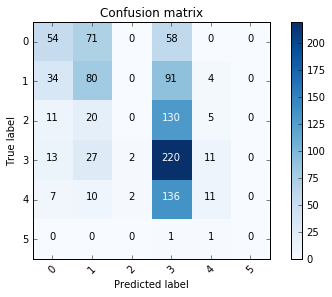

In [18]:
prediction = clf.predict(X_ts)
cnf_matrix = confusion_matrix(y_ts, prediction)
plot_confusion_matrix(cnf_matrix, classes=np.unique(y_s5))

In [19]:
print("Accuracy: ", sum(cnf_matrix.diagonal())/sum(sum(cnf_matrix)))

Accuracy:  0.365365365365


The accuracy is ok. As we are trying to predict between 5 labels and data is unbalanced. We can observate that the class 4 (platinum) has the highest weight. This could be happening because the data is unbalanced and also the stadistics are not that different between the middle elos (silver-gold-platinum).

### Multi-Binary SVM Classifier

As we had seen in the confusion matrix, platinum elo is by far the most frequent prediction. We believe that whis could happen because the data is not balanced (as we have more data from platinum elo players than the rest of elos).

Because of this reason we implement a multi-binary SVM (divide & conquer algorithm). Now, the data is classified by comparing each class against each other in a binary classification. This would not asure better results but it is another aproach that could fit well with the structure of the data.

First we will calculate the accuracy using a binary classifier for each pair of elos: 

In [26]:
accuracy = []
x_ds, y_ds = X_s5, y_s5

#We also perform the PCA for dimensionality reduction
pca = PCA()
X_ds = pca.fit_transform(preprocessing.scale(x_ds))
matrix = np.zeros((6, 6))
for first in np.unique(y_ds):
    for second in np.unique(y_ds):
        if first < second:
            y_ = np.logical_or(y_ds == first, y_ds == second)
            y_subset = y_ds[y_]
            x_subset = x_ds[y_.transpose()]
            clf = SVC(kernel='rbf')     #The kernel used is 'rbf'        
            values = cross_val_score(clf, x_subset, y_subset, cv=10)
            print('Class: ', first, " VS ", second,' Mean Accuracy :', np.mean(values), '\tSTD: ', np.std(values))
            matrix[first][second] = np.mean(values)
            matrix[second][first] = np.mean(values)
            accuracy.append(np.mean(values))            
print("Mean acc:", sum(accuracy)/len(accuracy))    

Class:  0  VS  1  Mean Accuracy : 0.566507193548 	STD:  0.000258913531678
Class:  0  VS  2  Mean Accuracy : 0.509697780603 	STD:  0.000264337915221
Class:  0  VS  3  Mean Accuracy : 0.685320364917 	STD:  0.000362418784677
Class:  0  VS  4  Mean Accuracy : 0.578235559593 	STD:  0.000259534809811
Class:  0  VS  5  Mean Accuracy : 0.990123390772 	STD:  0.00139228037819
Class:  1  VS  2  Mean Accuracy : 0.556956368096 	STD:  7.93816508851e-05
Class:  1  VS  3  Mean Accuracy : 0.624974542311 	STD:  0.000290491721852
Class:  1  VS  4  Mean Accuracy : 0.511977659574 	STD:  1.46252415796e-05
Class:  1  VS  5  Mean Accuracy : 0.992424359673 	STD:  0.00107044859283
Class:  2  VS  3  Mean Accuracy : 0.676894259095 	STD:  0.00033702743331
Class:  2  VS  4  Mean Accuracy : 0.56874643033 	STD:  9.32610185745e-05
Class:  2  VS  5  Mean Accuracy : 0.990495760056 	STD:  0.00133918977715
Class:  3  VS  4  Mean Accuracy : 0.613677547142 	STD:  0.000281089083099
Class:  3  VS  5  Mean Accuracy : 0.9954394

In [27]:
data = [{
    'z': matrix,
    'type': 'heatmap',
    'colorscale': [
        # Let first 10% (0.1) of the values have color rgb(0, 0, 0)
        [0, 'rgb(255,0,0)'],
        [1.0, 'rgb(0, 204, 0)']
    ]}]  
py.plot(data ,filename='matrix-visualization')

'https://plot.ly/~juanluismoralperez/13'

We can see that doing binary classification between classes:

In [28]:
X_ds = pca.fit_transform(preprocessing.scale(x_ds))
X_train, X_test, y_train, y_test = train_test_split(X_ds, y_ds, test_size=0.40, random_state=42)
classifiers = []
name_classifier = []
for first in np.unique(y_ds):
        for second in np.unique(y_ds):
            if first < second:
                y_ = np.logical_or(y_train == first, y_train == second)
                y_subset = y_train[y_]
                x_subset = X_train[y_.transpose()]
                clf = SVC(kernel='rbf', probability = True)
                clf.fit(x_subset, y_subset)
                classifiers.append(clf)
                name_classifier.append( [first,second] )

results = []
itr = 0
for clf in classifiers:
    predictions = clf.predict_proba(X_test)
    classifier = name_classifier[itr]
    results.append([ [classifier[np.argmax(prediction)], np.amax(prediction)] 
                    for prediction in predictions ]
                  )
    itr+=1

In [29]:
prediction = []
for i in range(0,len(results[0])):
    temp_clas = results[0][i][0]
    temp_prob = results[0][i][1]
    for j in range(1,len(results)):
        if temp_prob < results[j][i][1]:
            temp_clas = results[j][i][0]
            temp_prob = results[j][i][1]
    prediction.append(temp_clas)

In [30]:
cnf_matrix = confusion_matrix(y_test, prediction)

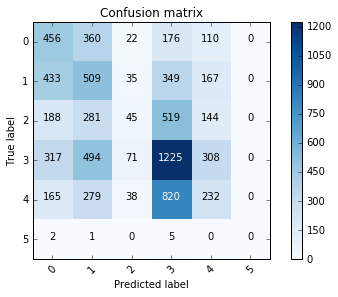

In [31]:
plot_confusion_matrix(cnf_matrix, classes=np.unique(y_ds), title='Confusion matrix')

In [32]:
print("Accuracy: ", sum(cnf_matrix.diagonal())/sum(sum(cnf_matrix)))

Accuracy:  0.318281512063


## Random Forest Classifier

As the two past methods didn't yield good results. We will try to classify the data using a RFC. 

With standard hyper-parameters:

In [34]:
clf = RandomForestClassifier(n_estimators=20)
values = cross_val_score(clf, X_tr, y_tr, cv=10)
print('Mean Accuracy :', np.mean(values), '\tSTD: ', np.std(values))

Mean Accuracy : 0.378764873381 	STD:  0.00611935823043


We will perform a Cross-Validated Grid Search (as before) for tunning the hyper-parameters:

In [46]:
estimators_range = np.arange(50, 1050, 50)
criterion_range = ["gini", "entropy"] 
param_grid = {"n_estimators": estimators_range, "criterion": criterion_range}

In [47]:
grid = GridSearchCV(RandomForestClassifier(), param_grid)

In [48]:
grid.fit(X_tr, y_tr)
print("The best classifier is: ", grid.best_estimator_)

The best classifier is:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=600, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [35]:
clf = RandomForestClassifier( criterion='entropy',n_estimators=600)
values = cross_val_score(clf, X_tr, y_tr, cv=10)
print('Mean Validation Accuracy :', np.mean(values), '\tSTD: ', np.std(values))
clf.fit(X_tr, y_tr)
print('Test Accuracy: ', clf.score(X_ts, y_ts))

Mean Validation Accuracy : 0.403438224614 	STD:  0.00956452311227
Test Accuracy:  0.335335335335


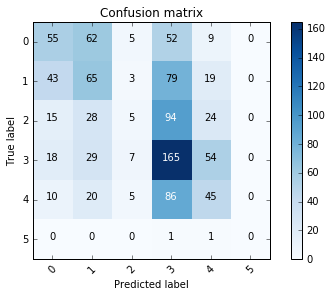

In [39]:
y_hat = clf.predict(X_ts)
cnf_matrix = confusion_matrix(y_ts, y_hat)
plot_confusion_matrix(cnf_matrix, classes=np.unique(y_s5), title='Confusion matrix')

In [40]:
print("Accuracy: ", sum(cnf_matrix.diagonal())/sum(sum(cnf_matrix)))

Accuracy:  0.335335335335


## Conclusion & results

We have seen that the best accuracy is obtanined using the SVC with a rbf kernel. We generate the prediction for the season 2016 using this classifier for further visualization.

In [12]:
clf = SVC(C=1000.0, gamma=0.01, kernel='rbf', tol=.003)
clf.fit(X_tr, y_tr)
predictions = clf.predict(X_ts)

We also export the predictions: 

In [ ]:
pickle.dump(predictions, open( "predictions_2016.pkl", "wb" ) )

# Results visualization

We believe that the best representation for the labels is a heatmap. Keep in mind that the leagues are not labeled in order, they are mapped as follows:

* 'bronze': 0 
* 'silver': 1 
* 'gold': 2
* 'platinum': 3
* 'diamond': 4
* 'master': 5

In [43]:
# Factor a number (the dimensions of the reshaped matrix from the vector)
def divisorGenerator(n):
    large_divisors = []
    for i in range(1, int(math.sqrt(n) + 1)):
        if n % i == 0:
            yield i
            if i*i != n:
                large_divisors.append(n / i)
    for divisor in reversed(large_divisors):
        yield divisor

print(list(divisorGenerator(999)))

[1, 3, 9, 27, 37.0, 111.0, 333.0, 999.0]


## Real Season 2016 ELOs

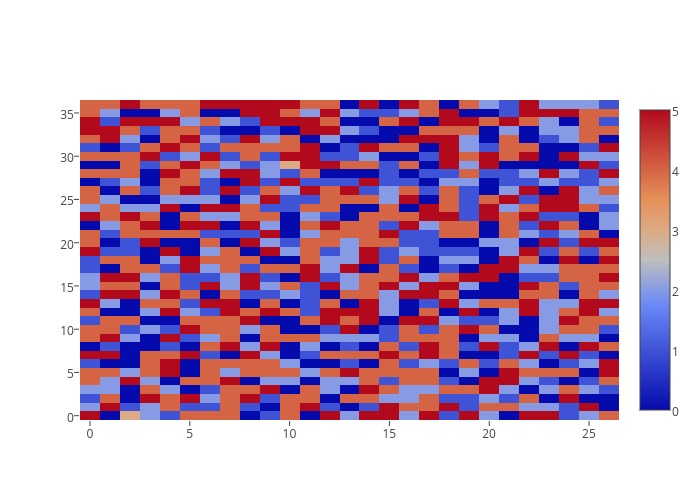

In [20]:
data = [
    go.Heatmap(
        z = np.reshape(y_s6, (37, 27))
    )
]
py.iplot(data, filename='heatmap_true_labels')

layout = go.Layout(title='Labels Heatmap', width=800, height=640)
fig = go.Figure(data=data, layout=layout)
py.image.save_as(data, filename='heatmap_true_labels.png')
from IPython.display import Image
Image('heatmap_true_labels.png')


## Predicted Season 2016 ELOs

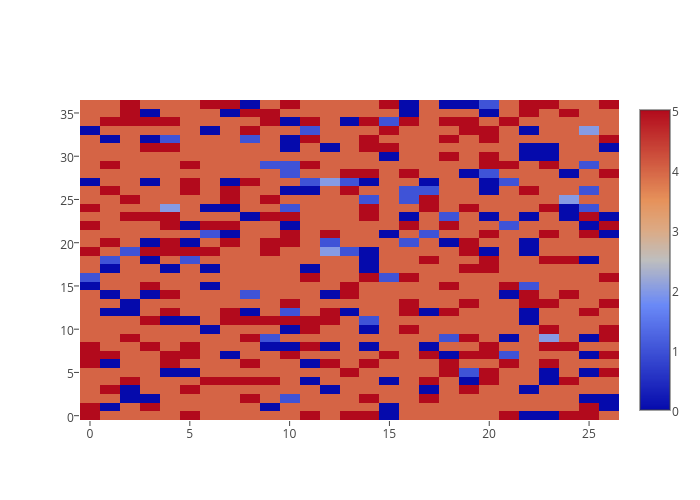

In [21]:
data = [
    go.Heatmap(
        z = np.reshape(predictions, (37, 27))
    )
]
py.iplot(data, filename='heatmap_predicted')

layout = go.Layout(title='Labels Heatmap', width=800, height=640)
fig = go.Figure(data=data, layout=layout)
py.image.save_as(data, filename='heatmap_predicted.png')
from IPython.display import Image
Image('heatmap_predicted.png')

## Precission and recall for the predicted data


In [28]:
import colorlover as cl
from IPython.display import HTML

In [34]:
ryb = cl.scales['3']['seq']['YlGn']
ryb

['rgb(247,252,185)', 'rgb(173,221,142)', 'rgb(49,163,84)']

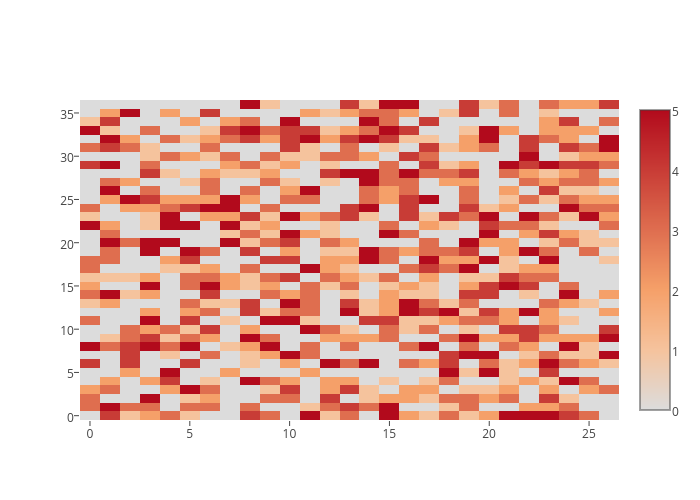

In [35]:
colorscale = [[0, ryb[0]], [5, ryb[2]]]

data = [
    go.Heatmap(
        z = np.reshape(np.absolute(y_s6-predictions), (37, 27)),
        colorscale = colorscale
    )
]
py.iplot(data, filename='heatmap_precission_recall')


layout = go.Layout(title='Labels Heatmap', width=800, height=640)
fig = go.Figure(data=data, layout=layout)
py.image.save_as(data, filename='heatmap_precission_recall.png')
from IPython.display import Image
Image('heatmap_precission_recall.png')

We can observe that althought the accuracy is not good when we make a mistake, usually it is less than 2 leagues. This means that the classifier only fails in classifying between adjacent leagues (e.g. bronze-silver).

## Final prediction error

In [54]:
print('League Prediction Error:', np.mean(np.absolute(y_s6-predictions)))

League Prediction Error: 0.962962962963


We have a mean error of 0.96.